In [1]:
import numpy as np
from PIL import Image
import scipy as sp 
import os
from pathlib import Path
from tqdm import tqdm 
import re
import skimage as ski

In [2]:
source_files = """
Y:/kau/диплом/data/brodatz-textures/1.1.01.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.02.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.03.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.04.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.05.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.06.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.07.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.08.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.09.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.10.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.11.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.12.tiff
Y:/kau/диплом/data/brodatz-textures/1.1.13.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.01.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.02.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.03.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.04.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.05.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.06.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.07.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.08.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.09.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.10.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.11.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.12.tiff
Y:/kau/диплом/data/brodatz-textures/1.2.13.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.01.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.02.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.03.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.04.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.05.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.06.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.07.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.08.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.09.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.10.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.11.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.12.tiff
Y:/kau/диплом/data/brodatz-textures/1.3.13.tiff
""".split()

len(source_files), source_files[:3]

(39,
 ['Y:/kau/диплом/data/brodatz-textures/1.1.01.tiff',
  'Y:/kau/диплом/data/brodatz-textures/1.1.02.tiff',
  'Y:/kau/диплом/data/brodatz-textures/1.1.03.tiff'])

In [3]:
def split_image_in_chunks(image, chunk_size):
    n1 = image.shape[0] // chunk_size
    n2 = image.shape[1] // chunk_size
    chunks = []
    for i in range(n1):
        for j in range(n2):
            chunks.append(image[i*chunk_size:(i+1)*chunk_size, j*chunk_size:(j+1)*chunk_size])
    return chunks

In [29]:
img = Image.open(source_files[0])
imgd = np.asarray(img)
imgd.shape, imgd.dtype

((512, 512), dtype('uint8'))

In [30]:
lbp = ski.feature.local_binary_pattern(imgd, 1, 8, 'default')
lbp.shape, lbp.dtype

((512, 512), dtype('float64'))

In [31]:
list(map(int,re.match(r'(\d+).(\d+).(\d+)', "1.2.13").groups()))

[1, 2, 13]

In [32]:
# For Brodatz Textures
CHUNK_SIZE = 100
dataset = []
labels = []
for path in tqdm(source_files, desc="images"):
    path = Path(path)
    img = Image.open(path)
    stem, suffix = path.stem, path.suffix
    
    _, subset, label = map(int, re.match(r'(\d+).(\d+).(\d+)', stem).groups())

    chunks = split_image_in_chunks(np.asarray(img), CHUNK_SIZE)
    dataset += chunks
    labels += [(subset, label)] * len(chunks)

    img.close()

images:   0%|          | 0/39 [00:00<?, ?it/s]

images: 100%|██████████| 39/39 [00:00<00:00, 399.86it/s]


In [34]:
dataset = np.array(dataset)
dataset.shape, dataset.dtype

((1950, 100, 100), dtype('uint8'))

In [35]:
labels = np.array(labels)
labels.shape, labels.dtype

((1950, 2), dtype('int64'))

In [36]:
np.save("Y:/kau/диплом/data/dataset/chunks.npy", dataset)
np.save("Y:/kau/диплом/data/dataset/labels.npy", labels)

---

In [38]:
def LBP(img, R, P, method):
    assert method != 'var'
    if method == 'default':
        assert P <= 16
    lbp = ski.feature.local_binary_pattern(img, P, R, method)
    return lbp.astype(np.uint16)

In [39]:
dataset = "Y:/kau/диплом/data/dataset"
# chunks.npy
# labels.npy

labels = np.load(f"{dataset}/labels.npy")
labels.shape, labels.dtype

((1950, 2), dtype('int64'))

In [40]:
np.shape(labels.flat)

(3900,)

In [41]:
# calculate lbp for whole image and then divide to avoid chunk boundary issues
def lbp_for_chunks(R, P, method):
    codename = f"lbp_R{R}_P{P}_{method[0]}"
    filename = f"{dataset}/{codename}.npy"
    print(f"{codename}..", end='')

    if Path(filename).is_file():
        print(f"exists, skipping.")
        return
    lbped_chunks = []
    for path in source_files:
        path = Path(path)
        img = Image.open(path)
        data = np.asarray(img)
        assert data.dtype == np.uint8
        assert len(data.shape) == 2
        lbp = LBP(data, R, P, method)
        lbped_chunks += split_image_in_chunks(lbp, CHUNK_SIZE)
        img.close()
    print('saving..', end='')
    assert len(lbped_chunks) == labels.shape[0]
    np.save(filename, np.array(lbped_chunks))
    print('done!')


(R=1,P=8, 'default'), (R=2,P=12,'default'), (R=1,P=8, 'uniform'), (R=2,P=12,'uniform'), (R=3,P=24,'uniform'), (R=5,P=36,'uniform')

In [42]:
%%time
lbp_for_chunks(1,8,'default')
lbp_for_chunks(2,12,'default')
lbp_for_chunks(1,8,'uniform')
lbp_for_chunks(2,12,'uniform')
lbp_for_chunks(3,24,'uniform')
lbp_for_chunks(5,36,'uniform')

lbp_R1_P8_d..saving..done!
lbp_R2_P12_d..saving..done!
lbp_R1_P8_u..saving..done!
lbp_R2_P12_u..saving..done!
lbp_R3_P24_u..saving..done!
lbp_R5_P36_u..saving..done!
CPU times: total: 37.2 s
Wall time: 38.2 s


---

In [43]:
def lbphist_for_chunks(R, P, method):
    codename = f"R{R}_P{P}_{method[0]}"
    lbp_filename = f"{dataset}/lbp_{codename}.npy"
    hist_filename = f"{dataset}/hist_{codename}.npy"
    print(f"{codename}..", end='')

    if not Path(lbp_filename).is_file():
        print("lbp absent.")
        return
    if Path(hist_filename).is_file():
        print("hist present, skipping.")
        return

    if method == 'uniform':
        nbins = P+2
    elif method == 'default':
        nbins = 2**P
    else:
        print(f"unsupported method '{method}'.")
        return
    
    lbpdata = np.load(lbp_filename)
    assert lbpdata.shape[0] == labels.shape[0]
    assert max(lbpdata.shape[1], lbpdata.shape[2]) < 2**16

    lbphist = np.zeros((labels.shape[0], nbins), dtype=np.uint32)
    for n,chunk in enumerate(lbpdata):
        lbphist[n] = np.bincount(chunk.flat, minlength=nbins)

    assert lbphist[0].sum() == lbpdata.shape[1] * lbpdata.shape[2]
    np.save(hist_filename, lbphist)
    print("done!")

In [44]:
%%time
lbphist_for_chunks(1,8,'default')
lbphist_for_chunks(2,12,'default')
lbphist_for_chunks(1,8,'uniform')
lbphist_for_chunks(2,12,'uniform')
lbphist_for_chunks(3,24,'uniform')
lbphist_for_chunks(5,36,'uniform')

R1_P8_d..done!
R2_P12_d..done!
R1_P8_u..done!
R2_P12_u..done!
R3_P24_u..done!
R5_P36_u..done!
CPU times: total: 469 ms
Wall time: 543 ms


---

In [74]:
a = np.load(f'{dataset}/hist_R1_P8_d.npy')
a

array([[ 829,  132,   24, ...,   34,   98,  820],
       [ 783,  162,   27, ...,   43,  131,  793],
       [ 790,  112,   30, ...,   30,  103,  799],
       ...,
       [ 960,  168,   47, ...,   59,  153, 1091],
       [ 868,  130,   69, ...,   67,  130,  963],
       [ 920,  151,   76, ...,   73,  133, 1047]],
      shape=(1950, 256), dtype=uint32)

In [75]:
b = np.load(f'{dataset}/lbp_R1_P8_d.npy')
b

array([[[ 65,   1, 129, ..., 225,   0,  16],
        [192, 255, 239, ..., 144, 246, 254],
        [193, 224, 243, ...,   7,   0, 240],
        ...,
        [  0, 255,  12, ...,  64, 248, 255],
        [  4, 251, 196, ...,  64, 248, 250],
        [  4, 251, 225, ...,   0, 184, 240]],

       [[ 17,   1,   1, ..., 177,  64, 241],
        [255, 175,   6, ...,  63,   0, 208],
        [112,  55,   4, ..., 255, 135,   0],
        ...,
        [134, 254, 255, ...,  57,   1,  64],
        [255, 193,   0, ...,  31, 159, 132],
        [243,   0,  20, ..., 191, 207, 133]],

       [[  0, 176, 241, ..., 241, 225, 225],
        [252, 255, 227, ...,   1,   0,  16],
        [145,  64, 112, ..., 135, 207,   6],
        ...,
        [127, 143,   6, ..., 108, 124, 255],
        [248, 255, 239, ..., 240, 120, 251],
        [128, 240, 247, ...,  64, 120, 251]],

       ...,

       [[  0, 223, 131, ..., 224, 112, 112],
        [215, 195, 135, ...,  32,  56, 249],
        [  3, 131, 199, ...,  28, 255,   1

---


# Visuzlisation

In [45]:
import matplotlib.pyplot as plt

In [46]:
dataset = Path("Y:/kau/диплом/data/dataset")
workdir = Path("Y:/kau/диплом/data/vis")

os.makedirs(workdir, exist_ok=True)

In [87]:
y = np.load(f"{dataset}/labels.npy")
print(y.shape, y.dtype)
label = y[:,1]
label_subset = y[:,0]

(1950, 2) int64


In [48]:
unique_labels = np.unique(label)
unique_labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [8]:
chunks = np.load(f"{dataset}/chunks.npy")
chunks.shape, chunks.dtype

((1950, 100, 100), dtype('uint8'))

In [50]:
chunks_cl = np.array([ chunks[label == k] for k in unique_labels ])
chunks_cl.shape

(13, 150, 100, 100)

In [51]:
random_chunk_ids = np.array([np.random.choice(150, 7, replace=False) for k in range(13)])
vis_chunks = np.array([chunks_cl[k,random_chunk_ids[k]] for k in range(13)])
vis_chunks.shape

(13, 7, 100, 100)

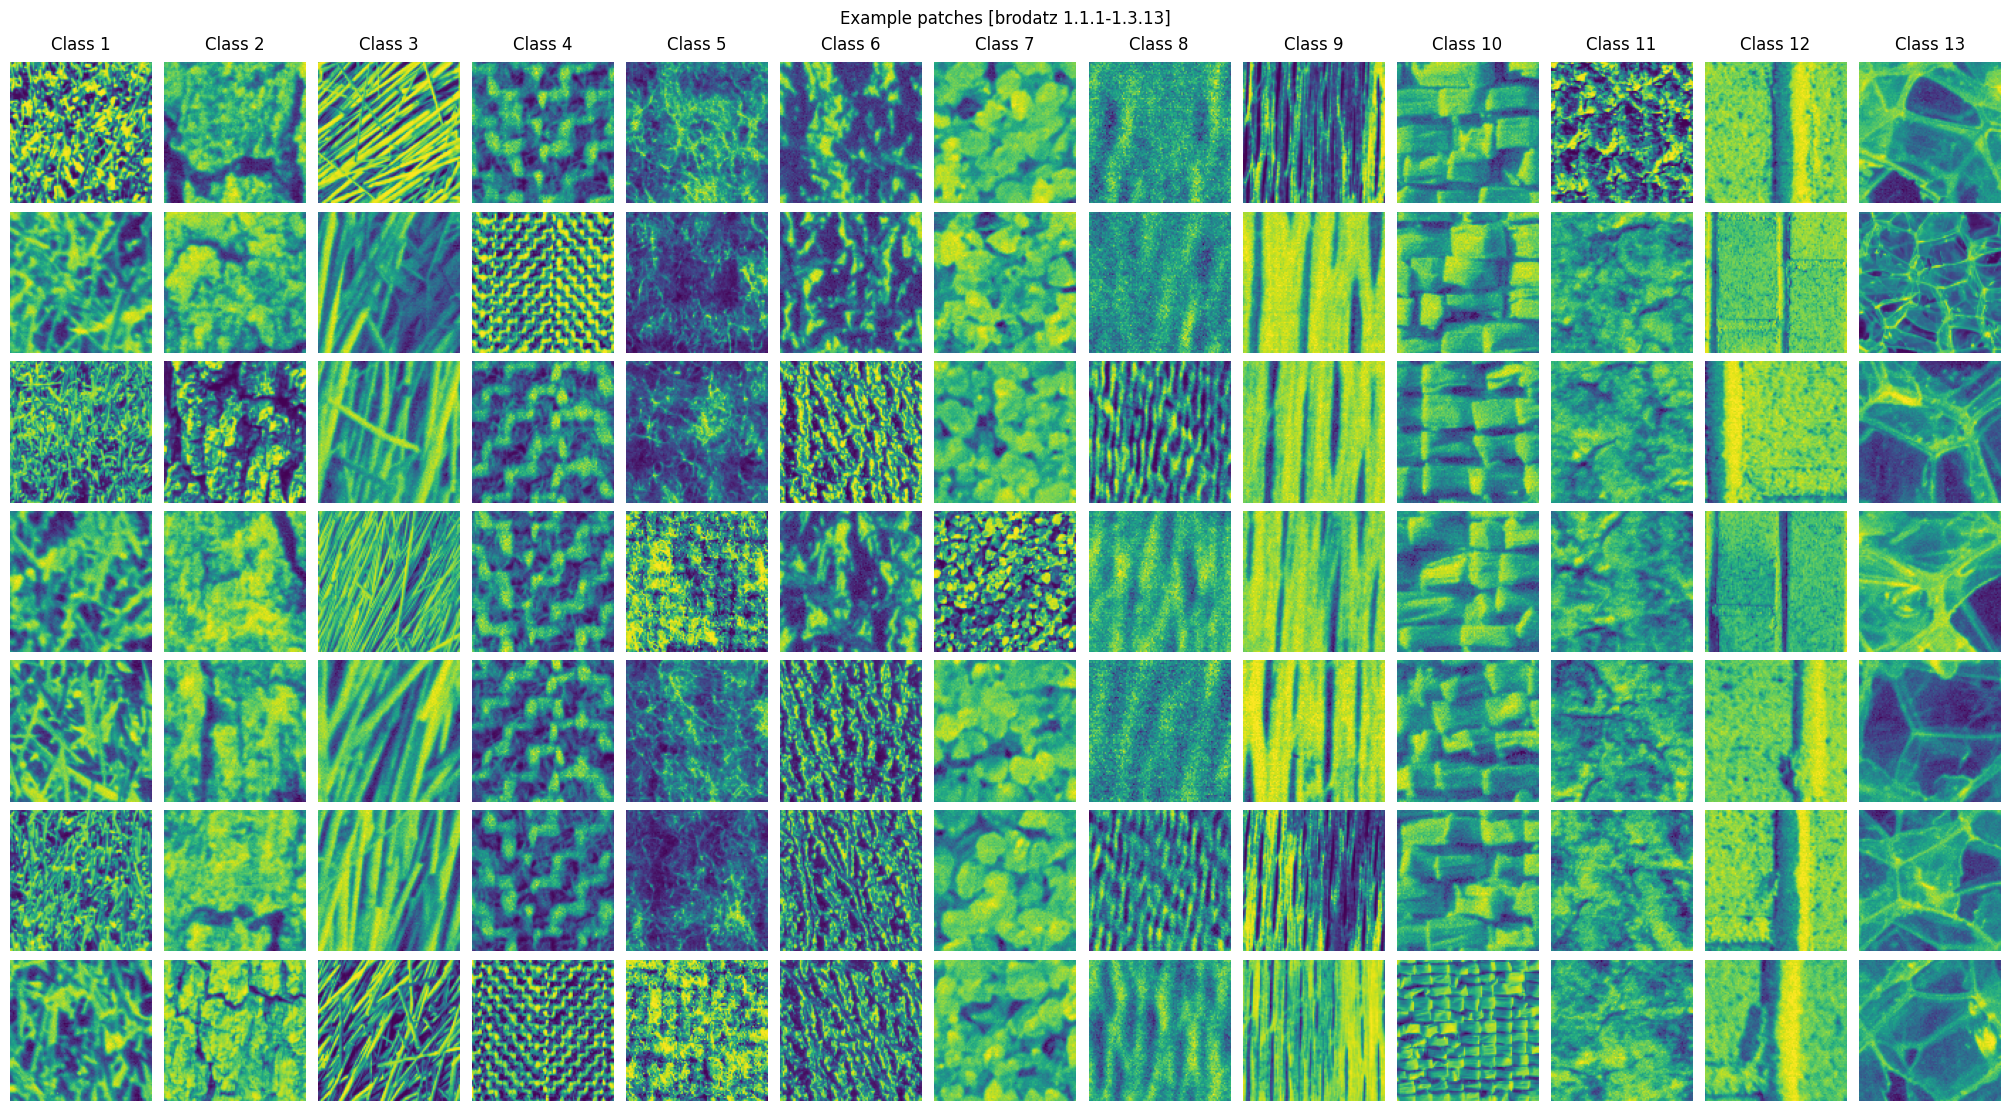

In [52]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches((20,11))
fig.suptitle('Example patches [brodatz 1.1.1-1.3.13]')
subfigs = fig.subfigures(nrows=1, ncols=13)
for k,sf in enumerate(subfigs.flat):
    sf.suptitle(f"Class {k+1}")
    axs = sf.subplots(nrows=7,ncols=1)
    for n,ax in enumerate(axs):
        ax.imshow(vis_chunks[k,n])
        ax.axis('off')

fig.savefig('plots/example_classes.png')

In [6]:
dataset = "data/dataset"
features = Path(dataset).glob("hist_*.npy")
features = list(map(np.load, features))

In [7]:
features

[array([[ 829,  132,   24, ...,   34,   98,  820],
        [ 783,  162,   27, ...,   43,  131,  793],
        [ 790,  112,   30, ...,   30,  103,  799],
        ...,
        [ 960,  168,   47, ...,   59,  153, 1091],
        [ 868,  130,   69, ...,   67,  130,  963],
        [ 920,  151,   76, ...,   73,  133, 1047]],
       shape=(1950, 256), dtype=uint32),
 array([[ 829, 1083,  704, ..., 1022,  820, 1537],
        [ 783, 1111,  732, ..., 1001,  793, 1418],
        [ 790,  980,  763, ...,  989,  799, 1464],
        ...,
        [ 960,  838,  645, ...,  865, 1091, 1658],
        [ 868,  763,  659, ...,  793,  963, 1590],
        [ 920,  813,  688, ...,  867, 1047, 1655]],
       shape=(1950, 10), dtype=uint32),
 array([[797,  56,  34, ...,  26,  33, 770],
        [791,  54,  46, ...,  51,  46, 779],
        [782,  61,  54, ...,  29,  25, 719],
        ...,
        [575,  48,  41, ...,  47,  68, 588],
        [485,  53,  33, ...,  33,  58, 532],
        [548,  67,  42, ...,  41,  63, 61

In [33]:
random_chunks_ids = np.random.choice(1950, 4, replace=False)
random_chunks = chunks[random_chunks_ids]
random_chunks.shape

(4, 100, 100)

In [14]:
chunk_features = [f[random_chunks_ids] for f in features]
[cf.shape for cf in chunk_features]

[(4, 256), (4, 10), (4, 4096), (4, 14), (4, 26), (4, 38)]

In [98]:
label_text = """
Grass (D9)                
Bark (D12)                
Straw (D15)               
Herringbone weave (D15)   
Woolen cloth (D19)        
Pressed calf leather (D24)
Beach sand (D29)          
Water (D38)               
Wood grain (D68)          
Raffia (D84)              
Pigskin (D92)             
Brick wall (D94)          
Plastic bubbles (D112)    
""".splitlines()[1:]
label_text = np.array(list(map(str.strip, label_text)))
label_text = label_text[label-1]
label_text.shape

(1950,)

In [99]:
label_text[random_chunks_ids]

array(['Wood grain (D68)', 'Pigskin (D92)', 'Woolen cloth (D19)',
       'Beach sand (D29)'], dtype='<U26')

In [27]:
import matplotlib.pyplot as plt

In [ ]:
H, bins = np.histogram(chunk_features[0], 50, range=(0,255), density=False)
H.min(), H, bins, 

(np.int64(0),
 array([440, 201, 111,  26,  10,   5,   3,   4,   5,   6,   3,   3,   6,
          6,   3,   6,  10,   8,  10,  11,  12,  15,   6,   4,   3,   6,
          8,   2,   4,   3,   7,   4,   5,   3,   3,   1,   5,   3,   3,
          7,   4,   4,   3,   2,   2,   1,   1,   1,   0,   3]),
 array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. , 107.1, 112.2, 117.3, 122.4, 127.5, 132.6,
        137.7, 142.8, 147.9, 153. , 158.1, 163.2, 168.3, 173.4, 178.5,
        183.6, 188.7, 193.8, 198.9, 204. , 209.1, 214.2, 219.3, 224.4,
        229.5, 234.6, 239.7, 244.8, 249.9, 255. ]))

(array([180.,  16.,   2.,   2.,   3.,   2.,   2.,   2.,   4.,   2.,   7.,
          4.,   3.,   2.,   1.,   0.,   0.,   0.,   2.,   3.,   3.,   3.,
          2.,   0.,   1.,   0.,   1.,   0.,   1.,   2.,   1.,   0.,   0.,
          1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([  0. ,   9.6,  19.2,  28.8,  38.4,  48. ,  57.6,  67.2,  76.8,
         86.4,  96. , 105.6, 115.2, 124.8, 134.4, 144. , 153.6, 163.2,
        172.8, 182.4, 192. , 201.6, 211.2, 220.8, 230.4, 240. , 249.6,
        259.2, 268.8, 278.4, 288. , 297.6, 307.2, 316.8, 326.4, 336. ,
        345.6, 355.2, 364.8, 374.4, 384. , 393.6, 403.2, 412.8, 422.4,
        432. , 441.6, 451.2, 460.8, 470.4, 480. ]),
 <BarContainer object of 50 artists>)

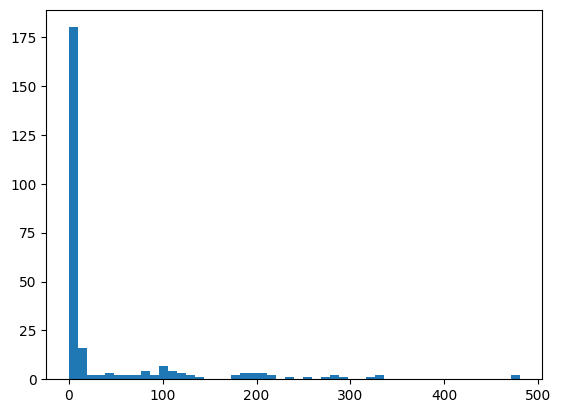

In [29]:
plt.hist(chunk_features[0][0], 50)

In [38]:
chunk_features[2][0].shape

(4096,)

In [40]:
ski.measure.block_reduce(chunk_features[2][0], 16).shape

(256,)

<BarContainer object of 256 artists>

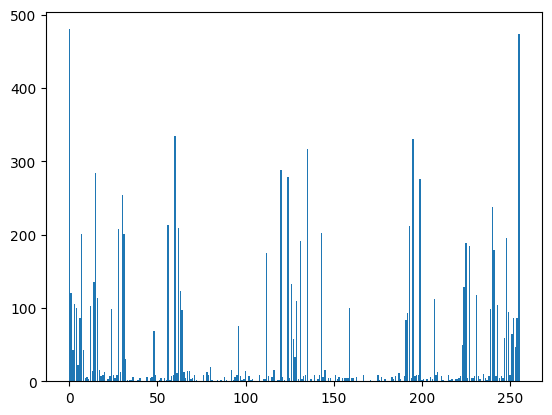

In [42]:
plt.bar(range(256), chunk_features[0][0])

In [59]:
chunk_features[1][0]

array([ 480,  579,  740, 1464, 2235, 1726,  870,  546,  474,  886],
      dtype=uint32)

In [71]:
plt.rcParams['font.family'] = 'Times New Roman'

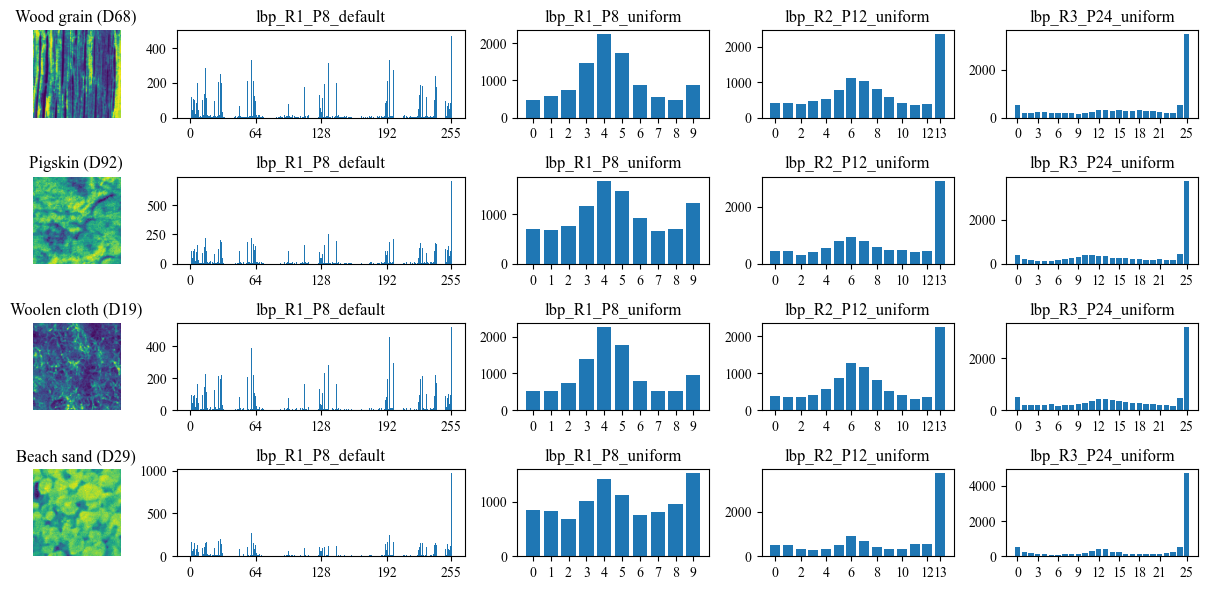

In [100]:
fig, axs = plt.subplots(4,5, width_ratios=[1,3,2,2,2])
for i,ar in zip(range(4), axs):
    ci = random_chunks_ids[i]
    ar[0].imshow(chunks[ci])
    ar[0].axis('off')
    ar[0].set_title(label_text[ci])

    ar[1].bar(range(256), chunk_features[0][i])
    ar[1].set_title('lbp_R1_P8_default')
    ar[1].set_xticks(list(range(0,256,64)) + [255])

    ar[2].bar(range(10), chunk_features[1][i])
    ar[2].set_title('lbp_R1_P8_uniform')
    ar[2].set_xticks(range(10))

    ar[3].bar(range(14), chunk_features[3][i])
    ar[3].set_title('lbp_R2_P12_uniform')
    ar[3].set_xticks(list(range(0,14,2)) + [13])

    ar[4].bar(range(26), chunk_features[4][i])
    ar[4].set_title('lbp_R3_P24_uniform')
    ar[4].set_xticks(list(range(0,24,3)) + [25])

fig.set_size_inches(12,6)
fig.tight_layout()
fig.savefig('plots/example_features.png', dpi=120, bbox_inches='tight')

In [110]:
features[0].shape

(1950, 256)

## Вибір кількості інтервалів для стандартних LBP

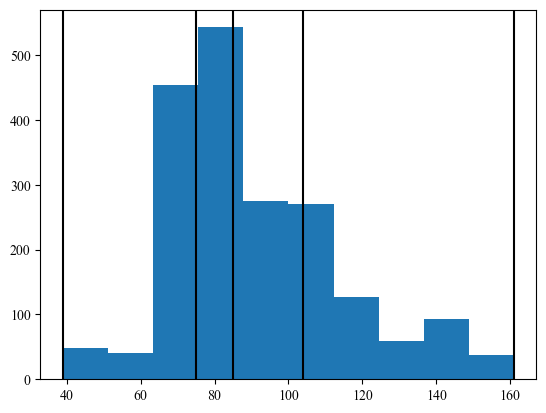

In [124]:
n_small_bins = (features[0] < 5).sum(axis=1)
qq = np.quantile(n_small_bins, [0,0.25,0.50,0.75,1])
plt.hist(n_small_bins)
[plt.axvline(q, c='k') for q in qq]

In [130]:
(qq / 256).round(3)

array([0.152, 0.293, 0.332, 0.406, 0.629])

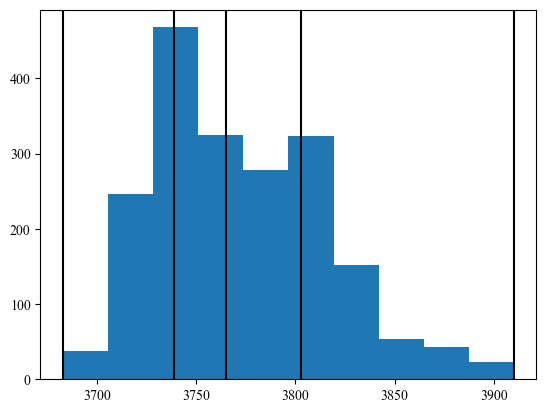

In [126]:
n_small_bins_R2P12 = (features[2] < 5).sum(axis=1)
qq_R2P12 = np.quantile(n_small_bins_R2P12, [0,0.25,0.50,0.75,1])
plt.hist(n_small_bins_R2P12)
[plt.axvline(q, c='k') for q in qq_R2P12]

In [129]:
(qq_R2P12 / 4096).round(2)

array([0.9 , 0.91, 0.92, 0.93, 0.95])

In [131]:
rand = np.random.default_rng(2701)

In [157]:
"""
function select_B
returns: a number B of equally spaced intervals such that there are no more than small_bin_ratio small bins across dataset on median
param B_range: tuple[int, int], (min B, max B)
param small_bin_threshold: a number of samples in a bin to consired it a small bin
param small_bin_ratio: a fraction of small bins of all bins you are trying to achieve 
"""
def select_B(feature, B_range: tuple[int,int], small_bin_threshold = 5, small_bin_ratio = 0.05):
    N, D = feature.shape
    Bmin, Bmax = B_range

    B = Bmax
    X = D // B
    rebinned = ski.measure.block_reduce(feature, (1,X), func=np.sum, cval=0)
    median_small_bins = np.median((rebinned < small_bin_threshold).sum(axis=1)) / rebinned.shape[1]
    print(f"B = {B}, X = {X}, median small bins = {median_small_bins}, Dnew = {rebinned.shape[1]}")
    Xold = X

    while median_small_bins > small_bin_ratio and B >= Bmin:
        B -= 1
        X = D // B
        if X == Xold: continue
        Xold = X
        rebinned = ski.measure.block_reduce(feature, (1,X), func=np.sum, cval=0)
        median_small_bins = np.median((rebinned < small_bin_threshold).sum(axis=1)) / rebinned.shape[1]
        print(f"B = {B}, X = {X}, median small bins = {median_small_bins}, Dnew = {rebinned.shape[1]}")

    print("end")



In [158]:
select_B(features[0], [10,100], small_bin_threshold=5, small_bin_ratio=0.05)

B = 100, X = 2, median small bins = 0.125, Dnew = 128
B = 85, X = 3, median small bins = 0.05813953488372093, Dnew = 86
B = 64, X = 4, median small bins = 0.015625, Dnew = 64
end


In [159]:
select_B(features[0], [10,86], small_bin_threshold=5, small_bin_ratio=0.05)

B = 86, X = 2, median small bins = 0.125, Dnew = 128
B = 85, X = 3, median small bins = 0.05813953488372093, Dnew = 86
B = 64, X = 4, median small bins = 0.015625, Dnew = 64
end


In [160]:
select_B(features[2], [10,400], small_bin_threshold=5, small_bin_ratio=0.05)

B = 400, X = 10, median small bins = 0.4317073170731707, Dnew = 410
B = 372, X = 11, median small bins = 0.39946380697050937, Dnew = 373
B = 341, X = 12, median small bins = 0.38011695906432746, Dnew = 342
B = 315, X = 13, median small bins = 0.3449367088607595, Dnew = 316
B = 292, X = 14, median small bins = 0.3310580204778157, Dnew = 293
B = 273, X = 15, median small bins = 0.3029197080291971, Dnew = 274
B = 256, X = 16, median small bins = 0.2890625, Dnew = 256
B = 240, X = 17, median small bins = 0.26141078838174275, Dnew = 241
B = 227, X = 18, median small bins = 0.2543859649122807, Dnew = 228
B = 215, X = 19, median small bins = 0.2361111111111111, Dnew = 216
B = 204, X = 20, median small bins = 0.22439024390243903, Dnew = 205
B = 195, X = 21, median small bins = 0.21428571428571427, Dnew = 196
B = 186, X = 22, median small bins = 0.1925133689839572, Dnew = 187
B = 178, X = 23, median small bins = 0.18994413407821228, Dnew = 179
B = 170, X = 24, median small bins = 0.181286549707

In [161]:
select_B(features[2], [0,64], small_bin_threshold=5, small_bin_ratio=0.05)

B = 64, X = 64, median small bins = 0.015625, Dnew = 64
end


## Rebinned features

In [167]:
# Rebinned lbp R1 P8 default
reb_r1p8d = ski.measure.block_reduce(features[0], block_size=(1,4), func=np.sum, cval=0)
print("reb_r1p8d:")
print("ratio of freqs <5. quartiles: ", np.quantile((reb_r1p8d < 5).sum(axis=1) / reb_r1p8d.shape[1], [0,0.25,0.5,0.75,1.0]))
print(reb_r1p8d.shape, reb_r1p8d.dtype)

# lbp R2 P12 default
reb_r2p12d = ski.measure.block_reduce(features[2], block_size=(1,46), func=np.sum, cval=0)
print("reb_r2p12d:")
print("ratio of freqs <5. quartiles: ", np.quantile((reb_r2p12d < 5).sum(axis=1) / reb_r2p12d.shape[1], [0,0.25,0.5,0.75,1.0]))
print(reb_r2p12d.shape, reb_r2p12d.dtype)

reb_r1p8d:
ratio of freqs <5. quartiles:  [0.       0.015625 0.015625 0.046875 0.265625]
(1950, 64) uint64
reb_r2p12d:
ratio of freqs <5. quartiles:  [0.         0.01111111 0.04444444 0.1        0.36666667]
(1950, 90) uint64


In [169]:
np.save('data/dataset/reb_hist_R1_P8_d.npy', reb_r1p8d)
np.save('data/dataset/reb_hist_R2_P12_d.npy', reb_r2p12d)
